In [44]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

def visual_analogy(model, train_loader, test_input_loader, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Z_few, Z_few_i, Z_sol, Z_sol_o, Z_sol_p = [[] for _ in range(5)]

        z_diffs = []
        for _, (input, output) in enumerate(train_loader):
            mu, logVar = model.encode(input.to(device))
            z_inp = model.reparameterize(mu, logVar)

            mu, logVar = model.encode(output.to(device))
            z_out = model.reparameterize(mu, logVar)

            z_diff = z_out.cpu().numpy().squeeze() - z_inp.cpu().numpy().squeeze()
            z_diffs.append(z_diff)
            print(z_diff)
        
        z_diffs = np.array(z_diffs)
        mu, logVar = model.encode(next(iter(test_input_loader)).to(device))
        z_input = model.reparameterize(mu, logVar).cpu().numpy().squeeze()
        
        print(z_input)
        # Z_avg, Z_sim, Z_cons, Z_rule = [[] for _ in range(4)]
        
        

        # Average rule vector
        z_avg = np.mean(z_diffs, axis=0)
        # Similarity rule vector (euclidean distance)
        # Z_temp = z_diffs
        # Z_euc = []
        # for t in range(len(Z_temp)):
        #     euclidean_sim = np.linalg.norm(Z_temp[t] - Z_sol[i])
        #     Z_euc.append(euclidean_sim)
        # idx = list(range(inp_index[i], inp_index[i+1]))[Z_euc.index(min(Z_euc))]
        # Z_sim.append(Z_few[idx])

        # # Check encoding consistency of all rule vectors
        # Z_temp = Z_few[inp_index[i]:inp_index[i+1]]
        # Z_cons.append(cosine_similarity(Z_temp))

            # Check encoding consistency of two rule vector approaches
            # Z_rule.append(np.dot(Z_avg[i], Z_few[idx])/(norm(Z_avg[i])*norm(Z_few[idx])))

        # Z_comp = Z_avg if comp == 'average' else Z_sim
        # for i in range(len(Z_comp)):
        z_res = []
        for i in range(len(z_avg)):
            z_out = z_input[i] + z_avg[i]
            out = model.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))
            out = torch.argmax(F.softmax(out, dim=1), dim=1)
            out = out.cpu().numpy().squeeze()

            z_res.append(out)
        
        return np.array(z_res)

In [2]:
from models.convolutional_vae import ConvolutionalVAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvolutionalVAE(
    in_channels=10, 
    num_filters=128, 
    latent_dim=64,
    l2_penalty=1e-5
).to(device)

checkpoint = torch.load('../../checkpoints/vae_checkpoint_1.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
import glob
import os
import json
import re

folder_path = "../../data/evaluation"
json_files = glob.glob(os.path.join(folder_path, "*.json"))

puzzle_ids = []

train_data = {}
test_inputs = {}
test_outputs = {}

for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        puzzle_id = re.search(r"([\da-f]+)\.json$", file).group(1)

        puzzle_ids.append(puzzle_id)
        train_data[puzzle_id] = data["train"]
        test_inputs[puzzle_id] = data["test"][0]['input']
        test_outputs[puzzle_id] = data["test"][0]['output']

Dataset size after augmentation: 3 -> 3
Dataset size after augmentation: 1 -> 1
[[-9.8690951e-01 -4.6371126e-01  1.6523848e+00 -1.2384788e+00
  -2.8629088e+00 -1.5219752e+00 -4.6039093e-01 -2.1308613e-01
  -4.6129727e-01 -2.2099133e-01 -2.0864177e+00 -1.9339271e+00
   1.3253367e-01 -7.2082692e-01  2.2496581e-02  1.3999985e+00
   1.5137510e+00  4.8114887e-01 -5.6823581e-01  4.5454174e-01
  -2.4657288e-01  2.2187824e+00  2.6846039e-01 -1.4450788e+00
   1.8909543e+00  2.8345079e+00  2.8902531e-01  7.9527080e-01
   9.7881854e-02 -3.4471653e-02 -7.7628422e-01 -1.0382252e+00
   5.4725283e-01 -5.7766628e-01  2.3364897e+00 -1.6396854e+00
   8.6054772e-02  2.1314976e+00 -1.4341012e+00 -1.2866476e+00
   2.3224483e+00 -1.0770515e+00  1.4311450e+00 -5.7560337e-01
   6.7692876e-02  1.2003474e+00  1.6531401e+00  2.6697636e-02
  -1.3372667e+00 -1.7988044e-01  5.3080451e-01  1.4209201e+00
  -8.6972016e-01  7.8281128e-01  1.2920836e+00 -2.8200679e+00
   3.2552779e-01  1.1092005e+00 -1.6082633e-01 -2.24

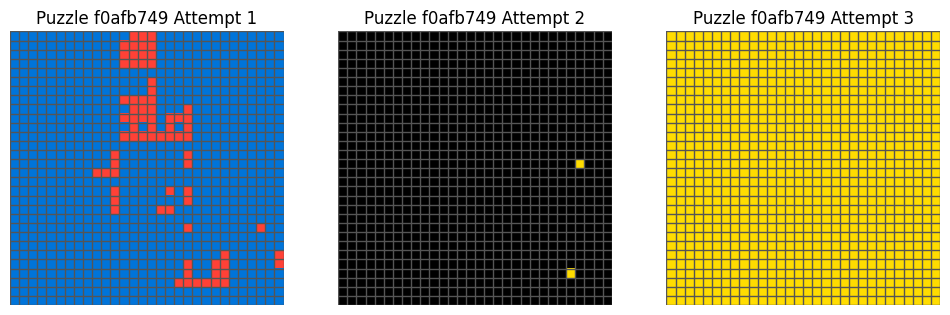

In [45]:
import matplotlib.pyplot as plt
from data.arc_dataset import GridDataset, PairedGridDataset
from data.scale_processing import scaling

from models.convolutional_vae import DataLoader
from utils.view import draw_grid

def normalize_fn(x, hw):
        h, w = hw
        # Normalize the grid to the target size
        return scaling(x, height=h, width=w, direction='norm')
    

for puzzle_id in puzzle_ids[:1]:
    training_grids = [(pair['input'], pair['output']) for pair in train_data[puzzle_id]]
    test_input = test_inputs[puzzle_id]
    test_output = test_outputs[puzzle_id]

    train_dataset = PairedGridDataset(training_grids, augment=False, normalize_fn=normalize_fn)
    batch_size = len(training_grids)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
    )

    test_input_dataset = GridDataset([test_input], augment=False, normalize_fn=normalize_fn)
    test_input_loader = DataLoader(
        test_input_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
    )

    result_grids = visual_analogy(model, train_loader, test_input_loader, device=device)

    fig, axes = plt.subplots(1, len(result_grids), figsize=(12, 6))
    for index, grid in enumerate(result_grids):
          draw_grid(axes[index], grid, f"Puzzle {puzzle_id} Attempt {index+1}")
        

